# Assignment 2: Hypothesis Testing

### Callista Christ

*Due*: Wed, Nov 13, 2019 in class

*Submission*: Complete this notebook and print out the output or electronically submit it. 

Everything you need to complete is marked with a TODO. For textual questions create a new cell under the question to respond to it.


## Motivation
In a standard randomized control trial, our null hypothesis is often trivial---nothing happens, no difference in the mean, no difference in the relative ranking. In this assignment, we look to generalize this idea to compare observed data against an assumed statistical model. That is, could the observed data plausibly be generated from the known model.


An air shower is a cascade of ionized particles and electromagnetic radiation produced in the atmosphere when a primary cosmic ray (i.e. one of extraterrestrial origin) enters the atmosphere. When a particle, which could be a proton, a nucleus, an electron, a photon, or (rarely) a positron, strikes an atom's nucleus in the air it produces many energetic hadrons. We have a detector that observes particles that reach a ground station and measures the particle energy and arrival time.

## Model and Data
We have the following theoretical model to describe particle behavior. The energy of each particle is drawn independent of arrival time from a [Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution). The particles arrive as a [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process). We have the following simulator:

In [1]:
import numpy as np
import pandas as pd

def simulate_burst(total):
    """Simulates a trial of total # of particles returns
       a dataframe with two columns one with observed time (in microsecs)
       and one with the energy in kilojoules.
    """
    t = 0
    data = []
    for trial in range(total):
        t += np.random.exponential(scale=1.0)
        obs = np.random.gamma(2.15,1.96, 1)[0]
        
        data.append({'otime_us':t, 'energy_kj':obs})
    
    return pd.DataFrame(data)

In addition to the simulator, you are given a daset of real observations [download](https://raw.githubusercontent.com/sjyk/cmsc21800/master/part.csv). You will write a function to load this dataset into a pandas dataframe. The dataset contains some missing values, the function should drop all rows with any missing values (i.e., NaN)

In [2]:
def load_data(filename):
    """TODO
       
       Input: a csv file of airburst observations
       Output: a pandas dataframe with no NaNs
    """
    df = pd.read_csv(filename, skiprows=1, sep=' ', names=['otime_us', 'energy_kj'])
    df.dropna(inplace=True)
    return df

In [3]:
df = load_data("particles.csv")
print(len(df))

996


## Pre-Processing

Before, we begin testing, we show analyze the data for potential problems.

**Q1. TODO *Compare particle energies generated from the simulator and the real data. If they do differ, explain how.***

In [4]:
df_sim = simulate_burst(len(df))

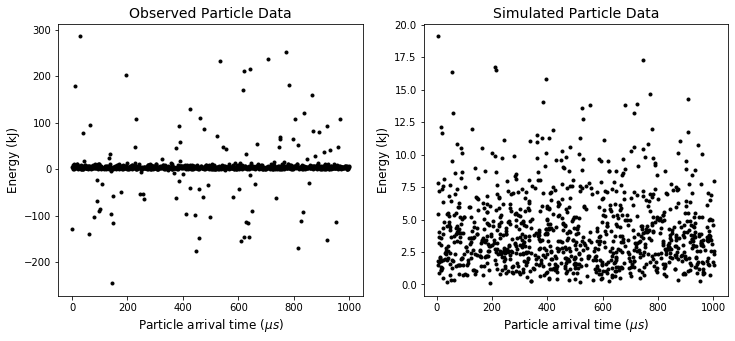

In [9]:
#Code for Q1
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.title("Observed Particle Data", fontsize=14)
plt.plot(df['otime_us'], df['energy_kj'], 'k.')
plt.xlabel("Particle arrival time ($\mu s$)", fontsize=12)
plt.ylabel("Energy (kJ)", fontsize=12)

fig.add_subplot(1, 2, 2)
plt.title("Simulated Particle Data", fontsize=14)
plt.plot(df_sim['otime_us'], df_sim['energy_kj'], 'k.')
plt.xlabel("Particle arrival time ($\mu s$)", fontsize=12)
plt.ylabel("Energy (kJ)", fontsize=12)
plt.show()

The data seems to differ since there are extremely large positive and negative values for the observed particle data (energies range from approximately -300 to 300 kJ) so there is a larger standard deviation (spread) which do not appear in the simulated data (energies range from approximately 0 to 17 kJ, small spread). Also, the simulated data have only positive values whereas the observed data contain negative values.  

**Q2. TODO *Your engineers tell you that all energy readings should be positive. Are there any negative values in either of the datasets? If so, is there any unexpected pattern to those values in terms of times they occur or values they take on?***

In [6]:
#Code for Q2
outliers_total = df[(df['energy_kj'] > 17.) | (df['energy_kj'] < 0.)] # finding outliers

# attempting to see if the outliers follow a normal distribution
samples = np.random.normal(np.mean(outliers_total['energy_kj']), np.std(outliers_total['energy_kj']), size=len(outliers_total))

In [7]:
print(np.mean(outliers_total['energy_kj']))
print(np.std(outliers_total['energy_kj']))

6.632118019204102
108.54612079475939


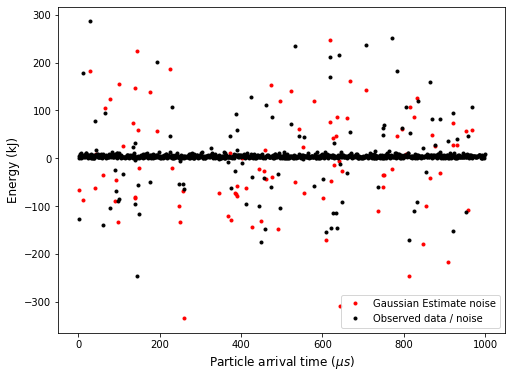

In [8]:
# from this plot it looks like the outliers are normally distributed (white noise)
plt.figure(figsize=(8, 6))
plt.plot(outliers_total['otime_us'], samples, 'r.', label='Gaussian Estimate noise')
plt.plot(df['otime_us'], df['energy_kj'], 'k.', label='Observed data / noise')
plt.xlabel("Particle arrival time ($\mu s$)", fontsize=12)
plt.ylabel("Energy (kJ)", fontsize=12)
plt.legend()
plt.show()

probplot function from stats generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default). probplot optionally calculates a best-fit line for the data and plots the results using Matplotlib or a given plot function.

Q-Q plots take your sample data, sort it in ascending order, and then plot them versus quantiles (i.e. “percentiles” which are points in your data below which a certain proportion of your data fall). calculated from a theoretical distribution. The number of quantiles is selected to match the size of your sample data. 

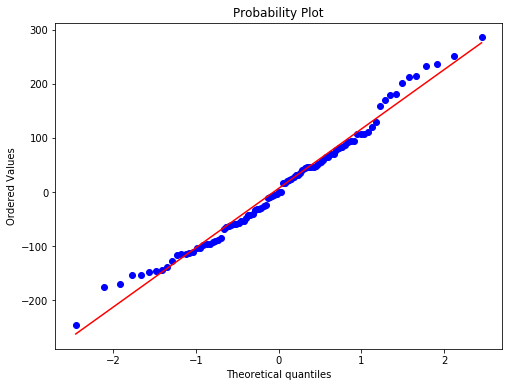

In [10]:
import scipy.stats as stats

plt.figure(figsize=(8,6))
stats.probplot(outliers_total['energy_kj'], dist="norm", plot=plt)
plt.show()

Yes, there are negative values in the observed particle data. The outliers (both positive and negative) appear to be normally distributed (i.e. white noise) from the Q-Q plot above that compares sample data against the quantiles of a normal distribution. Perhaps these values were due to limitations of the instrument or noise in the atmosphere. 

**Q3. TODO Are there any other energy readings that are suspect in the real dataset? Roughly what fraction of values are suspect**

In [11]:
#Code for Q3
print("fraction of suspicious values: %0.2f"% (len(outliers_total) / len(df)))

fraction of suspicious values: 0.10


Yeah the really large, positive energy readings are also suspicious. Roughly 10% of the orignal dataset contains problematic/suspicious values

**Based on your answers to Q1, Q2, Q3, write a function that cleans the real data by removing all problematic observations.** 

In [12]:
def clean(df):
    """TODO
    
       Input: a dataframe of a mix of erroneous and correct observations 
       Output: a dataframe with only the correct observations
    """
    return df[(df['energy_kj'] > 0.) & (df['energy_kj'] < 17.)]

In [13]:
cleaned_df = clean(df)

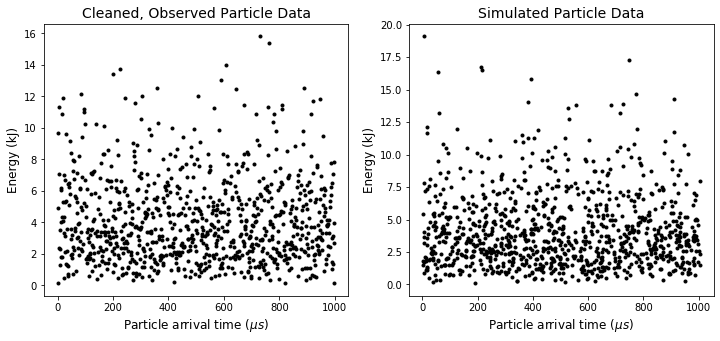

In [14]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.title("Cleaned, Observed Particle Data", fontsize=14)
plt.plot(cleaned_df['otime_us'], cleaned_df['energy_kj'], 'k.')
plt.xlabel("Particle arrival time ($\mu s$)", fontsize=12)
plt.ylabel("Energy (kJ)", fontsize=12)

fig.add_subplot(1, 2, 2)
plt.title("Simulated Particle Data", fontsize=14)
plt.plot(df_sim['otime_us'], df_sim['energy_kj'], 'k.')
plt.xlabel("Particle arrival time ($\mu s$)", fontsize=12)
plt.ylabel("Energy (kJ)", fontsize=12)
plt.show()

## Comparing the Energies
Now, we will compare the particle energies from the simulated data and the real data. Fill in the following hypothesis tests. *Be reasonable about this* You may not import methods from statistics packages that perform the test for you.

Z score that tests the null hypothesis:
$z = \frac{(\bar{x}_{sim} - \bar{x}_{obs})}{\sqrt{\frac{s_{sim}^2}{n_{sim}} + \frac{s_{obs}^2}{n_{obs}}}}$ that $\bar{x}_{sim} = \bar{x}_{obs}$, where $\bar{x}_{sim}$ is the mean energy of the simulated data and $\bar{x}_{obs}$ is the mean energy of the observed data.

In [35]:
def z_test_energy(simulated, real):
    """TODO
    
       Input: a dataframe of simulated observations, a dataframe of real observations 
       Output: a p-value based on the two-sample z-test
    """
    import scipy.stats as st

    # null hypothesis is that the two distributions means are the same (run a difference of means z-test)
    num = np.mean(simulated) - np.mean(real)
    denom = np.sqrt(((np.std(simulated))**2 / len(simulated)) + ((np.std(real))**2 / len(real)))
    z_score = num / denom
    p_value = (1 - st.norm.cdf(abs(z_score)))*2
    return p_value
    
    # code double checks z-score analysis with a prebuilt function
    # from statsmodels.stats import weightstats as stests
    # ztest ,pval1 = stests.ztest(simulated, x2=real,alternative='two-sided')
    # print(float(pval1))
    
def rs_test_energy(simulated, real):
    """TODO
    
       Input: a dataframe of simulated observations, a dataframe of real observations 
       Output: a p-value based on the two-sample rank-sum test using the normal approximation
    """
    import scipy.stats as st
    
    simulated['dataset'] = pd.Series("sim", index=simulated.index)
    real['dataset'] = pd.Series("real", index=real.index)
    combined_df = pd.concat([simulated, real], ignore_index=True)
    sorted_df = combined_df.sort_values(by=['energy_kj'])
    sorted_df.reset_index(inplace=True)
    ranked_real = sorted_df[sorted_df['dataset'] == 'real']
    real_rank_sum = np.sum(np.array(ranked_real.index.values)+1)
    SE = np.sqrt((len(simulated) * len(real) * (len(simulated) + len(real) + 1)) / 12)
    z_score = (real_rank_sum - len(real)*(len(real) + len(simulated) + 1) / 2) / SE
    p_value = (1 - st.norm.cdf(abs(z_score)))*2
    
    # code double checks z-score with a prebuilt ranksum from scipy
    #stat, p_value2 = st.ranksums(simulated['energy_kj'], real_data['energy_kj'])
    return p_value

#get the data
simulate_data = simulate_burst(10000)
real_data =  clean(load_data('part.csv'))
print('Two-Sample Z-Test: ', z_test_energy(simulate_data['energy_kj'], real_data['energy_kj']))
print('Rank Sum Test: ', rs_test_energy(simulate_data, real_data))

Two-Sample Z-Test:  0.47773385258805323
Rank Sum Test:  0.8791195053965468


From this initial run through, the difference in means / rank sum between the particle energies is not significant (since the p-values are substantially larger than $\alpha$=0.05), which means we fail to accept the alternative hypothesis (that something interesting is happening) and argue that the simulated and observed data do not significantly differ.

** There are a few parameters here that we selected: (1) how much data to simulate, and (2) we cleaned the real dataset prior to testing. Evaluate the effects of these choices.**

**Q1. TODO *Would it be beneficial to simulate 1e6 data points rather than the 10000 used above, why or why not?***

In [36]:
simulate_data2 = simulate_burst(1000000)
real_data2 =  clean(load_data('part.csv'))

print('Two-Sample Z-Test: ', z_test_energy(simulate_data2['energy_kj'], real_data2['energy_kj']))
print('Rank Sum Test: ', rs_test_energy(simulate_data2, real_data2))

Two-Sample Z-Test:  0.43947513482292866
Rank Sum Test:  0.9201992395927261


After running the 1e6 simulations it seems that the p-values are still larger than $\alpha=$0.05 and so it is still an insignificant result regardless of whether you use 1e6 or 10,000 simulations. When taking into account efficiency of algorithms, it would NOT be useful to simulate more data since you obtain a similar result (i.e. the difference in means / ranksum p-values are not significant and we fail to reject the null hypothesis) either way, but the 1e6 simulations takes significantly more computation time than running 10,000 simulations. 

Additionally, you have to be careful with simulating more data because this creates a dataset with many larger `otime_us` values. While there is not really a reason to believe that theoretical particle arrival time will cause a different variation in energy, for some datasets you can't extrapolate knowledge i.e. you shouldn't compare energies with a small particle arrival time to energies with a large particle arrival time because there may be two distinct processes occuring there . 

**Q2. TODO *Do the p-values change if you did not clean the dataset? Are both tests equally sensitive to the dirty data?***

In [37]:
#Code for Q2
simulate_data = simulate_burst(10000)
real_data_uncleaned =  load_data('part.csv')

print('Two-Sample Z-Test: ', z_test_energy(simulate_data['energy_kj'], real_data_uncleaned['energy_kj']))
print('Rank Sum Test: ', rs_test_energy(simulate_data, real_data_uncleaned))

Two-Sample Z-Test:  0.8739217958058163
Rank Sum Test:  0.7235307078050335


In [28]:
print("Average Energy (cleaned data): %0.2f kJ" % np.mean(real_data['energy_kj']))
print("Average Energy (dirty data): %0.2f kJ" % np.mean(real_data_uncleaned['energy_kj']))
print("Standard Deviation Energy (cleaned data) %0.2f kJ" % np.std(real_data['energy_kj']))
print("Standard Deviation Energy (dirty data) %0.2f kJ" %  np.std(real_data_uncleaned['energy_kj']))

Average Energy (cleaned data): 4.15 kJ
Average Energy (dirty data): 4.39 kJ
Standard Deviation Energy (cleaned data) 2.69 kJ
Standard Deviation Energy (dirty data) 33.98 kJ


The p-values change if you do not clean the data, but this is expected considering the standard deviation of the uncleaned dataset is a lot larger than the cleaned dataset; however, the p-value for the rank sum test does not change by much because the rank sum test is robust to outliers and thus it is not affected as much by outliers as the two-sample z test is.

## Comparing the Arrival Times
So far, we have only tested the particle energies. Another important aspect of our model is the arrival process (i.e., the times). 

Q1. TODO *Describe a hypothesis test that evaluates whether the arrival process significantly differs in the simulator from the observed data.*

We can do a difference of means ($\bar{x}_{sim} - \bar{x}_{obs}$) hypothesis test for the arrival times by analyzing the z score: 
$z = \frac{(\bar{x}_{sim} - \bar{x}_{obs})}{\sqrt{\frac{s_{sim}^2}{n_{sim}} + \frac{s_{obs}^2}{n_{obs}}}}$

where $\bar{x}_{sim}$ is the mean arrival time for the simulated data and $\bar{x}_{obs}$ is the mean for the observed data. The null hypothesis ($H_0$) would be that $\bar{x}_{sim} = \bar{x}_{obs}$ and the alternative hypothesis ($H_a$) would be that $\bar{x}_{sim} \neq \bar{x}_{obs}$.

Q2. TODO *Do your pre-processing choice above change? Why or why not?*

No the preprocessing code does not change because the problematic energies directly correspond to the problematic times and so by removing the problematic energies we also remove the problematic times and so we do not need to perform any additional preprocessing.

In [155]:
real_data = clean(load_data('part.csv'))
simulate_data = simulate_burst(len(real_data)) # only simulating as many data points as in the observed dataset 

In [156]:
def test_arrival_process(simulated, real):
    """TODO
    
       Input: a dataframe of simulated observations, a dataframe of real observations 
       Output: a p-value that determines the difference between the arrival processes
    """
    import scipy.stats as st

    # null hypothesis is that the two distributions means are the same (run a difference of means z-test)
    num = np.mean(simulated) - np.mean(real)
    denom = np.sqrt(((np.std(simulated))**2 / len(simulated)) + ((np.std(real))**2 / len(real)))
    z_score = num / denom
    p_value = (1 - st.norm.cdf(abs(z_score)))*2
    return p_value

In [159]:
p_value = test_arrival_process(simulate_data['otime_us'], real_data['otime_us'])
print("Two-Sample Z-Test:", p_value)

Two-Sample Z-Test: 0.008370432796243943


The result of this hypothesis test is that the difference in means of the arrival times are significant and thus we reject the null hypothesis in favor of the alternative hypothesis since our p value is less than $\alpha = 0.05$